In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
## 학습 함수
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss = 0

    model.train()
    for x,y in dataloader:
        x, y= x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches

    return tr_loss.item()

def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()

    with torch.no_grad():
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()
    return eval_loss, pred

def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list) + 1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker='.')
    plt.plot(epochs, val_loss_list, label='val_err', marker='.')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
## 데이터 로더 함수
def make_dataset(x_train, x_val, y_train, y_val, batch_size=32):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, x_val_tensor, y_val_tensor

In [4]:
path = 'https://bit.ly/irisdata_csv'
data = pd.read_csv(path)
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
target = 'Species'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=.3, random_state=20)


scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

train_loader, x_val_ts, y_val_ts = make_dataset(x_train, x_val, y_train, y_val, 32)

In [10]:
n_feature = x_train.shape[1]
n_class = len(le.classes_)

model = nn.Sequential(
    nn.Linear(
        n_feature, n_class
    )
).to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.1)

In [17]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 0.206554, val loss : 0.283590
Epoch 2, train loss : 0.174817, val loss : 0.292559
Epoch 3, train loss : 0.163170, val loss : 0.293698
Epoch 4, train loss : 0.172952, val loss : 0.278949
Epoch 5, train loss : 0.162069, val loss : 0.274824
Epoch 6, train loss : 0.183508, val loss : 0.272378
Epoch 7, train loss : 0.173871, val loss : 0.270451
Epoch 8, train loss : 0.172466, val loss : 0.268534
Epoch 9, train loss : 0.159673, val loss : 0.264073
Epoch 10, train loss : 0.161852, val loss : 0.262224
Epoch 11, train loss : 0.143270, val loss : 0.261961
Epoch 12, train loss : 0.164122, val loss : 0.266494
Epoch 13, train loss : 0.158546, val loss : 0.272384
Epoch 14, train loss : 0.145356, val loss : 0.256262
Epoch 15, train loss : 0.173576, val loss : 0.252647
Epoch 16, train loss : 0.151685, val loss : 0.256402
Epoch 17, train loss : 0.146080, val loss : 0.260343
Epoch 18, train loss : 0.164431, val loss : 0.253750
Epoch 19, train loss : 0.147638, val loss : 0.257166
Ep

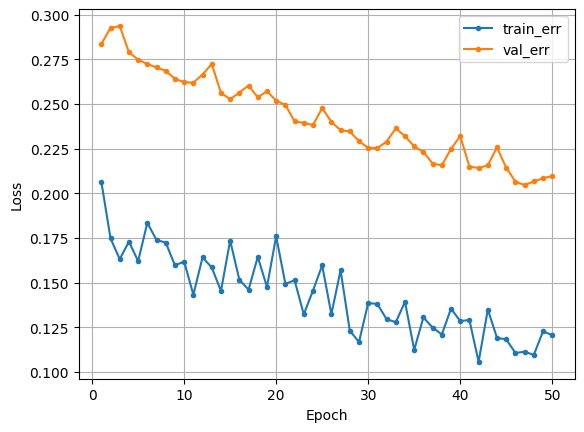

In [18]:
dl_learning_curve(tr_loss_list,val_loss_list)

In [19]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

print(pred.cpu().numpy()[:3])

[[ 6.7836666   1.8855482  -8.503666  ]
 [-3.7591276   1.9427037  -0.70153713]
 [-3.782547    1.7036884  -0.612823  ]]


In [20]:
pred = nn.functional.softmax(pred, dim=1)
print(pred[:3])

tensor([[9.9259e-01, 7.4054e-03, 2.2781e-07],
        [3.1086e-03, 9.3075e-01, 6.6139e-02],
        [3.7573e-03, 9.0682e-01, 8.9427e-02]], device='cuda:0')


In [21]:
pred = np.argmax(pred.cpu().numpy(), axis=1)
pred[:3]

array([0, 1, 1])

In [22]:
print(confusion_matrix(y_val_ts.cpu().numpy(), pred))
print(classification_report(y_val_ts.cpu().numpy(), pred, target_names=le.classes_))

[[13  0  0]
 [ 0 18  0]
 [ 0  4 10]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.82      1.00      0.90        18
   virginica       1.00      0.71      0.83        14

    accuracy                           0.91        45
   macro avg       0.94      0.90      0.91        45
weighted avg       0.93      0.91      0.91        45

